In [72]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import pandas as pd
import zipfile

In [1]:
zip_path = 'totalData_zestimate.csv.zip'

with zipfile.ZipFile(zip_path, 'r') as z:
    with z.open("totalData_zestimate.csv") as f:  # Change "yourfile.csv" to the actual filename
        df = pd.read_csv(f)

df = df.iloc[:, 1:]

/var/folders/r6/j2xslqfj0lg0bxy1nj8b6fzm0000gn/T/ipykernel_93343/4001251298.py:7: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f)


In [2]:
columns = ['PostalCode', 'PoolPrivateYN', 'ViewYN', 'DaysOnMarket', 'BedroomsTotal',
            'BathroomsTotalInteger', 'YearBuilt', 'LivingArea',  'AttachedGarageYN', 
            'ElementarySchool', 'ElementarySchoolDistrict', 'MiddleOrJuniorSchool', 'MiddleOrJuniorSchoolDistrict', 
            'HighSchool', 'HighSchoolDistrict', 'ClosePrice', 'June', 'July', 'August', 'September',
            'October', 'November', 'December', 'January']
df = df[columns]

In [75]:
df.isna().sum()

PostalCode                          0
PoolPrivateYN                   10858
ViewYN                           8226
DaysOnMarket                        0
BedroomsTotal                       0
BathroomsTotalInteger              17
YearBuilt                          72
LivingArea                         49
AttachedGarageYN                10136
ElementarySchool                77683
ElementarySchoolDistrict        91072
MiddleOrJuniorSchool            77599
MiddleOrJuniorSchoolDistrict    91072
HighSchool                      73650
HighSchoolDistrict              22809
ClosePrice                          2
June                            41187
July                            41187
August                          41187
September                       41187
October                         41187
November                        41187
December                        41187
January                         41187
dtype: int64

In [76]:
df.groupby('PostalCode').count()['PoolPrivateYN'].median() # median of how many houses there are per postal code

15.0

In [77]:
def fill_missing(df):
    output = df.copy()
    def mean_impute_numerical(col):
        return col.fillna(col.mean())
    
    def median_impute(col):
        median = col.median()
        return col.fillna(median)
    
    # impute these values based on the mean value of postal code
    for col in ['BathroomsTotalInteger', 'YearBuilt', 'LivingArea']:
        new_col = output.groupby('PostalCode')[col].transform(mean_impute_numerical)
        output[col] = new_col

    # if percentage of True is above 0.5, fill in missing values with True, else False
    def mean_impute_TF(col):
        if col.mean() > 0.5:
            return col.fillna(True)
        return col.fillna(False)
    
    # use above function to impute
    for col in ['PoolPrivateYN', 'ViewYN', 'AttachedGarageYN']:
        new_col = output.groupby('PostalCode')[col].transform(mean_impute_TF)
        output[col] = new_col

    # fill in other missing values for homes that are in their only zip code
    for col in ['BathroomsTotalInteger', 'YearBuilt', 'LivingArea']:
        output[col] = mean_impute_numerical(output[col])
    for col in ['PoolPrivateYN', 'ViewYN', 'AttachedGarageYN']:
        output[col] = mean_impute_TF(output[col])

    # fill in missing values for monthly zestimates with median
    for col in ['June', 'July', 'August', 'September', 'October', 
                'November', 'December', 'January']:
        output[col] = median_impute(output[col])
        
    output = output.dropna(subset=['ClosePrice']) # drop where ClosePrice is missing
    
    return output

In [78]:
def engineer_schools(df):
    copy = df.copy()
    # no need for elementary school district or middle school district because all values in those are missing
    cols = ['ElementarySchool', 'MiddleOrJuniorSchool', 'HighSchool', 'HighSchoolDistrict']
    sum = pd.Series(np.zeros(df.shape[0]), index=df.index)
    for col in cols:
        sum += (1- copy[col].isna())
    copy['total_schools'] = sum
    copy = copy.drop(columns=['ElementarySchool', 'ElementarySchoolDistrict','MiddleOrJuniorSchool', 
                              'MiddleOrJuniorSchoolDistrict', 'HighSchool', 'HighSchoolDistrict'])
    return copy

In [79]:
def binary_encode(df):
    output = df.copy()
    columns = ['PoolPrivateYN', 'ViewYN', 'AttachedGarageYN']
    for col in columns:
        output[col] = output[col].astype(int)
    return output

def engineer_postal_code(df):
    copy = df.copy()
    def cut_off(value):
        if len(value) > 5:
            return int(value[:4]) # if the postal code is in the form XXXXX-XXXX, cut off the second part
        return int(value)
    copy['PostalCode'] = copy['PostalCode'].transform(cut_off)
    return copy
    

In [80]:
def preprocess(df):
    output = df.copy()
    output = fill_missing(output)
    output = engineer_schools(output)
    output = binary_encode(output)
    output = engineer_postal_code(output)
    return output

In [81]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.activations import swish
import matplotlib.pyplot as plt

In [82]:
features = [
    "PoolPrivateYN", "ViewYN", "DaysOnMarket", "BedroomsTotal",
    "BathroomsTotalInteger", "YearBuilt", "LivingArea",
    "AttachedGarageYN", "total_schools", 'PostalCode', 'June'
]


target = "ClosePrice"  # Replace with actual target column name
cleaned_df = preprocess(df)
display(cleaned_df)

X = cleaned_df[features]
y = cleaned_df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/var/folders/r6/j2xslqfj0lg0bxy1nj8b6fzm0000gn/T/ipykernel_35444/2917587044.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return col.fillna(False)
/var/folders/r6/j2xslqfj0lg0bxy1nj8b6fzm0000gn/T/ipykernel_35444/2917587044.py:18: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return col.fillna(True)
/var/folders/r6/j2xslqfj0lg0bxy1nj8b6fzm0000gn/T/ipykernel_35444/2917587044.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead

,PostalCode,PoolPrivateYN,ViewYN,DaysOnMarket,BedroomsTotal,BathroomsTotalInteger,YearBuilt,LivingArea,AttachedGarageYN,ClosePrice,June,July,August,September,October,November,December,January,total_schools
0,94025,0,0,0,3.0,2.0,1948.0,1831.0,0,3000000.0,1.619339e+06,1.603775e+06,1.591971e+06,1.597171e+06,1.606118e+06,1.607777e+06,1.603538e+06,1.600010e+06,1.0
1,90254,1,1,0,5.0,5.0,2024.0,5000.0,1,7750000.0,2.860421e+05,2.865972e+05,2.862386e+05,2.863269e+05,2.856763e+05,2.850506e+05,2.845458e+05,2.888148e+05,1.0
2,93906,0,0,0,2.0,1.0,1950.0,863.0,1,575000.0,2.860421e+05,2.865972e+05,2.862386e+05,2.863269e+05,2.856763e+05,2.850506e+05,2.845458e+05,2.888148e+05,1.0
3,90046,0,0,0,3.0,1.0,1923.0,1338.0,1,1810000.0,2.860421e+05,2.865972e+05,2.862386e+05,2.863269e+05,2.856763e+05,2.850506e+05,2.845458e+05,2.888148e+05,0.0
4,92057,0,0,0,4.0,4.0,2009.0,3203.0,1,1135000.0,2.860421e+05,2.865972e+05,2.862386e+05,2.863269e+05,2.856763e+05,2.850506e+05,2.845458e+05,2.888148e+05,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91067,92651,0,1,248,4.0,3.0,1977.0,2822.0,1,4000000.0,4.084544e+05,4.055077e+05,4.025490e+05,4.004506e+05,3.981077e+05,3.950837e+05,3.916743e+05,3.873717e+05,1.0
91068,92352,0,1,546,6.0,7.0,1985.0,5846.0,1,4600000.0,5.953888e+05,5.938179e+05,5.931190e+05,5.935593e+05,5.949074e+05,5.955063e+05,5.950698e+05,5.933673e+05,1.0
91069,92365,0,1,480,3.0,2.0,1984.0,1909.0,1,170000.0,2.860421e+05,2.865972e+05,2.862386e+05,2.863269e+05,2.856763e+05,2.850506e+05,2.845458e+05,2.888148e+05,1.0
91070,95121,0,0,23,3.0,2.0,1965.0,1720.0,1,1071000.0,2.860421e+05,2.865972e+05,2.862386e+05,2.863269e+05,2.856763e+05,2.850506e+05,2.845458e+05,2.888148e+05,1.0


In [83]:
X.isna().sum()

PoolPrivateYN            0
ViewYN                   0
DaysOnMarket             0
BedroomsTotal            0
BathroomsTotalInteger    0
YearBuilt                0
LivingArea               0
AttachedGarageYN         0
total_schools            0
PostalCode               0
June                     0
dtype: int64

In [84]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [85]:
def r2_score(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))  # Residual sum of squares
    mean_y = tf.reduce_mean(y_true)
    ss_tot = tf.reduce_sum(tf.square(y_true - mean_y))  # Total sum of squares
    return 1 - (ss_res / (ss_tot + tf.keras.backend.epsilon()))  # Avoid division by zero

Epoch 1/90


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2277/2277 ━━━━━━━━━━━━━━━━━━━━ 3s 947us/step - loss: 693593.6875 - mae: 693593.6875 - r2_score: -0.1016 - val_loss: 445882.3750 - val_mae: 445882.3750 - val_r2_score: 0.2686
Epoch 2/90
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 2s 944us/step - loss: 470254.1250 - mae: 470254.1250 - r2_score: 0.4010 - val_loss: 438845.2812 - val_mae: 438845.2812 - val_r2_score: 0.2593
Epoch 3/90
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 2s 953us/step - loss: 466910.5000 - mae: 466910.5000 - r2_score: 0.4196 - val_loss: 428408.6250 - val_mae: 428408.6250 - val_r2_score: 0.2286
Epoch 4/90
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 2s 882us/step - loss: 450527.8438 - mae: 450527.8438 - r2_score: 0.4314 - val_loss: 421246.2812 - val_mae: 421246.2812 - val_r2_score: 0.3674
Epoch 5/90
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 2s 867us/step - loss: 456121.4688 - mae: 456121.4688 - r2_score: 0.4386 - val_loss: 422318.5625 - val_mae: 422318.5625 - val_r2_score: 0.3164
Epoch 6/90
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 2s 886us/step - loss: 450003.7188 - mae: 450003.

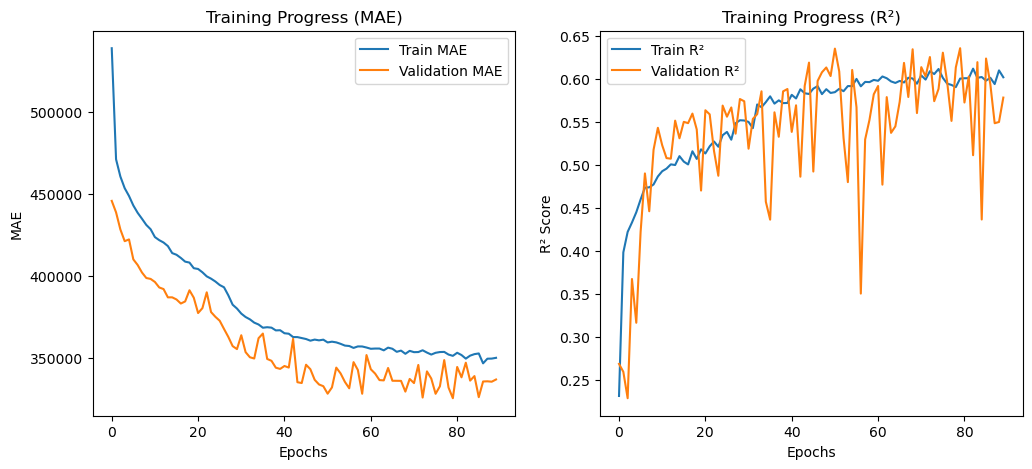

In [86]:
model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(16, activation='relu'),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dense(64, activation=swish),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    LeakyReLU(alpha=0.1),
    Dense(32, activation=swish),
    Dense(16, activation='relu'),
    Dense(1)  # No activation for regression
])

# Compile model with R² and MAE
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mae', metrics=['mae', r2_score])

# Train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=90, batch_size=32, verbose=1)

# Evaluate
loss, mae, r2 = model.evaluate(X_test, y_test)
print(f"Final MAE: {mae:.2f}")
print(f"Final R²: {r2:.4f}")

# Plot MAE & R²
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.title('Training Progress (MAE)')

plt.subplot(1, 2, 2)
plt.plot(history.history['r2_score'], label='Train R²')
plt.plot(history.history['val_r2_score'], label='Validation R²')
plt.xlabel('Epochs')
plt.ylabel('R² Score')
plt.legend()
plt.title('Training Progress (R²)')

plt.show()
